In [1]:
# Normal imports
import pandas as pd
import time
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from time import time
%matplotlib inline

## General GenSim packages to import

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.test.utils import datapath
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

# pyLDAvis for gensim

import pyLDAvis
pyLDAvis.enable_notebook()
import pyLDAvis.gensim  # don't skip this

# Temporal models
from gensim.models import LdaSeqModel
from gensim.models.wrappers.dtmmodel import DtmModel

# Enable logging for gensim - to get pink boxes
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# Sklearn CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# A lot of warnings
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# The all important, Pickle
import pickle


### Functions to help with topic model understanding

In [1606]:
    topic_count = []
    confidence = []
    both = []
    one_topic = 0
    two_topic = 0
    three_topic = 0
    four_more_topic = 0
    for num, doc in enumerate(range(len(corpus_vect_gensim))):
        item = lda_model.get_document_topics(corpus_vect_gensim[num])
        if len(item) == 1:
            topic_count.append(item[0][0])
            confidence.append(item[0][1])
            one_topic += 1
        else:
            pickin_best = []
            for it in item:
                pickin_best.append(it[1])
            for it in item:
                if it[1] == max(pickin_best):
                    topic_count.append(it[0])
                    confidence.append(it[1])
            if len(item) == 2:
                two_topic += 1
            if len(item) == 3:
                three_topic += 1
            if len(item) >= 4:
                four_more_topic += 1
                
    enumed = list(range(len(topic_count)))
    topic_winners_time = pd.DataFrame(data = [enumed, topic_count]).T
    topic_winners_time.columns = ['chap_num', 'topic_winner']             

In [2]:
def document_breakdown(sparse_corpus):
    # Bound even though it doesn't say much
    print("Bound of LDA model: ", lda_model.bound(corpus_vect_gensim))

    # Estimate for the corpus
    topic_count = []
    confidence = []
    both = []
    one_topic = 0
    two_topic = 0
    three_topic = 0
    four_more_topic = 0
    for num, doc in enumerate(range(len(sparse_corpus))):
        item = lda_model.get_document_topics(sparse_corpus[num])
        if len(item) == 1:
            topic_count.append(item[0][0])
            confidence.append(item[0][1])
            one_topic += 1
        else:
            pickin_best = []
            for it in item:
                pickin_best.append(it[1])
            for it in item:
                if it[1] == max(pickin_best):
                    topic_count.append(it[0])
                    confidence.append(it[1])
            if len(item) == 2:
                two_topic += 1
            if len(item) == 3:
                three_topic += 1
            if len(item) >= 4:
                four_more_topic += 1
# Topic winners over time
    enumed = list(range(len(topic_count)))
    topic_winners_time = pd.DataFrame(data = [enumed, topic_count]).T
    topic_winners_time.columns = ['chap_num', 'topic_winner']                

# Creating a scatter plot by topic, but first a dataframe
    topic_hue = pd.DataFrame([topic_count, confidence]).T
    topic_hue.columns = ['topic', 'confidence']
    sns.boxplot(x="topic", y="confidence", data=topic_hue)
#sns.lmplot(x=0, y=1, data= topic_hue, fit_reg=False, hue='trunc_model', legend=False, size = 8)

    print(len(topic_count))
# topic_count = []
# # Count of different doc topics
# for num, doc in enumerate(range(len(corpus_vect_gensim))):
#     topic_count.append(lda_model.get_document_topics(corpus_vect_gensim[num][0][0]))
    fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize=(15,10))
    axes[0,0].hist(topic_count, bins = num_of_topics)
    axes[0, 0].set_title('Winning Topic Count');
    axes[0,1].hist(confidence);
    axes[0,1].set_title('Confidence Histogram');
    axes[1,0].bar(x = 'chap_num', height = 'topic_winner', data = topic_winners_time);
    axes[1,0].set_title('Winner by Chapter');
    axes[1,1].bar(x = ['One Topic', 'Two Topic', 'Three Topic', 'Four or More Topic'], height = [one_topic, two_topic, three_topic, four_more_topic])
    axes[1,1].set_title('Topic Classification Split')

    
#     topic_map_names = {0 : 'Progressive', 1 : 'World Order', 2 : 'Colonial', 3 : 'Establishing Empire', 5 : '1930s',
#                6 : 'Civil War', 7 : 'America at War', 8 : 'Cold War', 9 : 'World War II' }

#     replacement = topic_winners_time['topic_winner'] 

#     topic_winners_time['topic_winner_names'] = replacement

#     topic_winners_time['topic_winner_names'] = topic_winners_time['topic_winner_names'].map(topic_map_names)
    
#     fig, ax = plt.subplots(figsize=(15,10))

#     sns.barplot(x = 'chap_num', y = 'topic_winner', data = topic_winners_time, hue = 'topic_winner_names', palette="rainbow")

#     def change_width(ax, new_value) :
#         for patch in ax.patches :
#             current_width = patch.get_width()
#             diff = current_width - new_value

#             # we change the bar width
#             patch.set_width(new_value)

#             # we recenter the bar
#             patch.set_x(patch.get_x() + diff * .5)
#     plt.title('Topics of American Foreign Relations')
#     plt.xlabel('Chapter Number')
#     plt.ylabel(' ')
#     plt.legend(loc = 'upper left')
#     change_width(ax, .5)
#     plt.show()

In [3]:
# Creating a readable dictionary file for pyLDA and DTM
def readable_dict(vectorized_corpus, vectorizer):
    corpus_df = pd.DataFrame(vectorized_corpus.A, columns=vectorizer.get_feature_names())
    corpus_all_list = []
    for corpus in vectorized_corpus.toarray():
        coprus_words = []
        for idd, y in enumerate(corpus):
            if y == 0:
                pass
            else:
                coprus_words.append(corpus_df.columns[idd])
        corpus_all_list.append(coprus_words)

In [4]:
def word_impact(lda_model):
        topic_words = []
        topic_words_id = []
        topic_impact = []
        topic_id = []
        for x in range(num_of_topics):
            topic_terms = lda_model.show_topic(x, 30)
            for y in topic_terms:
                word, impact = y
                topic_words.append(word)
                topic_impact.append(impact)
                topic_id.append(x)
            topic_terms = lda_model.get_topic_terms(x, 30)
            for z in topic_terms:
                word_id, _ = z
                topic_words_id.append(word_id)
        word_topic_impact = pd.DataFrame([topic_words, topic_words_id, topic_impact, topic_id]).T
        word_topic_impact.columns = ['word', 'words_id', 'impact', 'topic_num']
        rank_count = word_topic_impact.groupby(by = 'words_id').count().sort_values('words_id', ascending = False) #.reset_index().reset_index()
        rank_count = rank_count.sort_values('impact', ascending = False).reset_index().reset_index()
        rank_count
        rank_count.drop(labels = ['topic_num', 'word',], axis = 1, inplace = True)
        rank_count.columns = ['count_topic_rank', 'words_id', 'count']
        rank_count.head()
        word_topic_impact['words_id'] = word_topic_impact['words_id'].astype(int)
        word_topic_impact['topic_num'] = word_topic_impact['topic_num'].astype(int)
        word_topic_impact['impact'] = word_topic_impact['impact'].astype(float)
        word_topic_impact = word_topic_impact.merge(rank_count, how = 'left', on = 'words_id')
        impact_avg = word_topic_impact.groupby(by = 'word').mean().reset_index()
        impact_avg.drop(labels = ['words_id', 'topic_num', 'count_topic_rank', 'count'], axis = 1, inplace = True)
        impact_avg.columns = ['word', 'impact_avg']
        impact_avg.head()
        word_topic_impact = word_topic_impact.merge(impact_avg, how = 'left', on = 'word')
        return word_topic_impact.sort_values(by = 'impact_avg', ascending = False).head(15)

In [5]:
chapters_all = pd.read_csv('./text/sec_chapters_all.csv')

In [10]:
year_all = pd.read_csv('./text/sec_para_year.csv')

In [7]:
date_text = pd.read_csv('./text/sec_para_date.csv')

In [8]:
chapters_all = chapters_all.set_index('Unnamed: 0')

In [11]:


num_of_topics = 10

vectorizer = CountVectorizer(stop_words='english', ngram_range = (1, 3), min_df = 5, max_df = .35)


corpus_count = vectorizer.fit_transform(year_all['para_lemma'])


#transform to gensim acceptable objects
vocab = vectorizer.get_feature_names()

id2word = dict([(i, s) for i, s in enumerate(vocab)])

corpus_vect_gensim = gensim.matutils.Sparse2Corpus(corpus_count, documents_columns=False)

readable_dict(corpus_count, vectorizer)
t0 = time()
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_vect_gensim,
                                           id2word=id2word,
                                           num_topics=num_of_topics, 
                                           update_every=1,
                                           passes=10,
                                           per_word_topics=True,
                                           alpha='asymmetric',
                                           eta = .15,
                                            decay = .7,
                                            random_state = 33
                                           )

print("done in %0.3fs." % (time() - t0))

done in 22.144s.


In [12]:
corpus_count.shape

(1465, 4793)

In [13]:
corpus_count

<1465x4793 sparse matrix of type '<class 'numpy.int64'>'
	with 100551 stored elements in Compressed Sparse Row format>

In [1660]:
readable_dict(corpus_count, vectorizer)

In [1661]:
# # Build LDA model
# lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_vect_gensim,
#                                            id2word=id2word,
#                                            num_topics=num_of_topics, 
#                                            update_every=1,
#                                            passes=10,
#                                            per_word_topics=True,
#                                            alpha='asymmetric',
#                                            eta = 1,
#                                             decay = .7
#                                            )

In [1697]:
fname = datapath("/Users/bengreer/Documents/github/DSI-US-5/Capstone/gensim_lda_model/sec_chap_equal")

lda_model_id = LdaModel.load(fname, mmap='r')

In [1708]:
for idx, x in enumerate(lda_model.print_topics(num_words = 20)):
    print("Topic {}:".format(idx), x)
doc_lda = lda_model[corpus_vect_gensim]

Topic 0: (0, '0.020*"missionary" + 0.017*"seward" + 0.011*"destiny" + 0.010*"indian" + 0.009*"hawaii" + 0.008*"cotton" + 0.008*"ocean" + 0.007*"hawaiian" + 0.007*"manifest" + 0.007*"manifest destiny" + 0.007*"railroad" + 0.006*"native" + 0.006*"merchant" + 0.006*"slave" + 0.005*"vessel" + 0.005*"lincoln" + 0.005*"jackson" + 0.005*"expedition" + 0.005*"1890" + 0.005*"california"')
Topic 1: (1, '0.021*"mckinley" + 0.010*"1898" + 0.009*"tariff" + 0.008*"spain" + 0.007*"cuban" + 0.007*"carnegie" + 0.006*"1890" + 0.006*"philippine" + 0.006*"seward" + 0.006*"annexation" + 0.006*"canada" + 0.006*"steel" + 0.006*"railway" + 0.005*"canal" + 0.005*"caribbean" + 0.005*"oil" + 0.005*"fleet" + 0.005*"sugar" + 0.005*"1890s" + 0.005*"monroe"')
Topic 2: (2, '0.020*"soviet" + 0.017*"league" + 0.014*"postwar" + 0.014*"soviet union" + 0.010*"conference" + 0.010*"1920s" + 0.008*"communist" + 0.007*"arrangement" + 0.006*"1919" + 0.006*"state britain" + 0.006*"united state britain" + 0.005*"paris" + 0.005*"

In [1699]:
lda_model.print_topics(num_words = 20)

[(0,
  '0.009*"british" + 0.008*"government" + 0.006*"treaty" + 0.005*"force" + 0.005*"washington" + 0.005*"country" + 0.005*"american" + 0.004*"great" + 0.004*"britain" + 0.004*"new" + 0.004*"power" + 0.004*"french" + 0.003*"polk" + 0.003*"president" + 0.003*"japan" + 0.003*"claim" + 0.003*"mexico" + 0.003*"congress" + 0.003*"western" + 0.003*"right"'),
 (1,
  '0.015*"china" + 0.010*"chinese" + 0.007*"policy" + 0.007*"world" + 0.007*"foreign" + 0.006*"power" + 0.006*"country" + 0.006*"new" + 0.005*"economic" + 0.005*"communist" + 0.005*"force" + 0.005*"president" + 0.005*"nation" + 0.004*"american" + 0.004*"affair" + 0.004*"government" + 0.003*"come" + 0.003*"asia" + 0.003*"people" + 0.003*"control"'),
 (2,
  '0.009*"new" + 0.008*"world" + 0.008*"trade" + 0.005*"mckinley" + 0.005*"million" + 0.005*"market" + 0.004*"foreign" + 0.004*"tariff" + 0.004*"gold" + 0.004*"order" + 0.004*"economic" + 0.004*"policy" + 0.004*"american" + 0.004*"international" + 0.004*"nation" + 0.003*"british" +

In [ ]:
document_breakdown(corpus_vect_gensim)

In [14]:
topic_map_names = {0 : 'Progressive', 1 : 'World Order', 2 : 'Colonial', 3 : 'Establishing Empire', 5 : '1930s',
               6 : 'Civil War', 7 : 'America at War - lukewarm', 8 : 'Cold War', 9 : 'World War II' }

replacement = topic_winners_time['topic_winner'] 

topic_winners_time['topic_winner_names'] = replacement

topic_winners_time['topic_winner_names'] = topic_winners_time['topic_winner_names'].map(topic_map_names)
# for x in topic_winners_time['topic_winner']:
#     str(x).map(x, topic_map_names[x])

NameError: name 'topic_winners_time' is not defined

In [1268]:
topic_map_names[0]

'Progressive'

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))

sns.barplot(x = 'chap_num', y = 'topic_winner', data = topic_winners_time, hue = 'topic_winner_names', palette="rainbow")

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
plt.title('Topics of American Foreign Relations')
plt.xlabel('Chapter Number')
plt.ylabel(' ')
plt.legend()
change_width(ax, .5)
plt.show()

In [1707]:
cm = CoherenceModel(model= lda_model, corpus = corpus_vect_gensim, coherence='u_mass')
coherence = cm.get_coherence()  # get coherence value
coherence

-0.6919493152718381

In [1136]:
slim = word_impact(lda_model)
slim

,word,words_id,impact,topic_num,count_topic_rank,count,impact_avg
270,franklin,764,0.038861,9,85,1,0.038861
150,league,998,0.021175,5,237,1,0.021175
0,vietnam,1863,0.027712,0,53,2,0.018834
33,vietnam,1863,0.009955,1,53,2,0.018834
360,mckinley,1065,0.028873,12,35,2,0.016736
194,mckinley,1065,0.004600,6,35,2,0.016736
148,soviets,1634,0.003021,4,0,5,0.015446
22,soviets,1634,0.002953,0,0,5,0.015446
241,soviets,1634,0.013603,8,0,5,0.015446
30,soviets,1634,0.032950,1,0,5,0.015446


In [ ]:
# Creating a readable dictionary file for pyLDA and DTM

corpus_df = pd.DataFrame(corpus_count.A, columns=vectorizer.get_feature_names())
corpus_all_list = []
for corpus in corpus_count.toarray():
    coprus_words = []
    for idd, y in enumerate(corpus):
        if y == 0:
            pass
        else:
            coprus_words.append(corpus_df.columns[idd])
    corpus_all_list.append(coprus_words)

In [ ]:
# Setting up a pyLDA readable dict
id2word = corpora.Dictionary(corpus_all_list)

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus_vect_gensim))  # a measure of how good the model is. lower the better.

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus_vect_gensim, id2word)
vis



 '0.047*"vietnam" + 0.019*"johnson" + 0.015*"kennedy" + 0.007*"advisers" + 0.006*"1917" + 0.006*"southeast" + 0.006*"american military" + 0.006*"american troops" + 0.005*"communist" + 0.005*"expedition" + 0.005*"points" + 0.005*"fourteen" + 0.004*"secret" + 0.004*"loss" + 0.004*"germans" + 0.003*"combat" + 0.003*"wartime" + 0.003*"paris" + 0.003*"nationality" + 0.003*"postwar"'),
 (8,

In [1342]:
"fourteen", '1917', 'paris', 'points'

# from gensim.models import Word2Vec
corpus_word_vec = Word2Vec(corpus_all_list)
corpus_word_vec.most_similar(['17'],['1917'])

[('naval base', 0.33084410429000854),
 ('world economy', 0.31406405568122864),
 ('hawaii', 0.30527088046073914),
 ('states soviet union', 0.30237674713134766),
 ('model', 0.2927151620388031),
 ('relations united', 0.29063913226127625),
 ('importantly', 0.2870829701423645),
 ('turkey', 0.2865292429924011),
 ('black', 0.2846500277519226),
 ('progress', 0.2772141098976135)]

In [1113]:
pylda_table = vis.topic_info

In [1280]:
vis.token_table

,Topic,Freq,Term
term,,,
1226,1,0.077977,12
1226,2,0.155954,12
1226,3,0.311908,12
1226,8,0.155954,12
1226,9,0.155954,12
1933,1,0.304488,1865
1933,2,0.152244,1865
1933,3,0.228366,1865
1933,5,0.076122,1865


#### Save the LDA Model

In [1115]:
lda_model.save(fname= './gensim_lda_model/sec_chap_equal20')
pickle.dump(corpus_vect_gensim ,open('./gensim_lda_model/sec_chap20_corpus_vect.txt', 'wb'))
pickle.dump(corpus_count ,open('./gensim_lda_model/sec_chap20_corpus_count.txt', 'wb'))

### Load in Primary Source Documents

In [1116]:
df_pres = pd.read_csv('./text/df_pres.csv')
df_prog = pd.read_csv('./text/df_prog.csv')
df_pri = pd.read_csv('./text/df_pri.csv')

## All Primary Source Comparison

In [1117]:
df_pri = df_pri[7:]

In [1288]:
# Splitting up into predictable time periods

df_pri['doc'].fillna(' ', inplace = True)
df_pri['chapter_lemma'].fillna(' ', inplace = True)

df_b_1865 = df_pri[df_pri['year'] < 1865]
df_b_1865['doc'].fillna(' ', inplace = True)
df_b_1865['chapter_lemma'].fillna(' ', inplace = True)

df_1865_1913 = df_pri[df_pri['year'] < 1913]
df_1865_1913 = df_1865_1913[df_1865_1913['year'] > 1865]

df_1913_1945 = df_pri[df_pri['year'] < 1945]
df_1913_1945 = df_1913_1945[df_1913_1945['year'] > 1913]

df_a_1945 = df_pri[df_pri['year'] > 1945]

/Users/bengreer/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


# All documents

Bound of LDA model:  -1192319.3415237665
1718


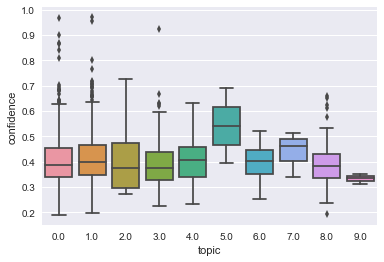

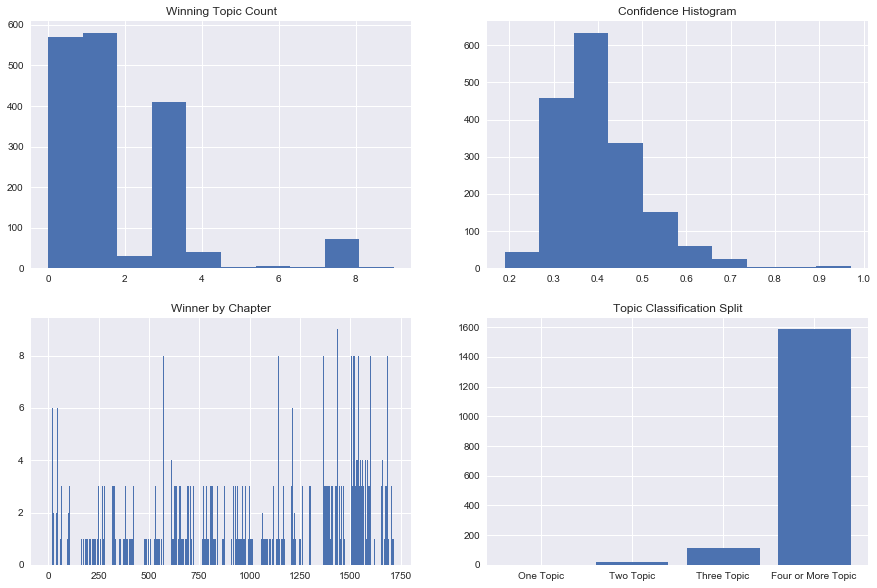

In [1652]:
# Transforming Primary doc's into correct vectorized matrix

sec_pri_countvec = vectorizer.transform(df_pri['chapter_lemma'])

pri_corpus_vect_gensim = gensim.matutils.Sparse2Corpus(sec_pri_countvec, documents_columns=False)

document_breakdown(pri_corpus_vect_gensim)

# Before 1865

Bound of LDA model:  -1192312.6972382665
1210


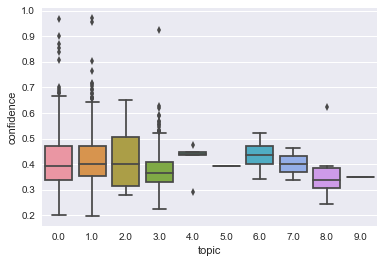

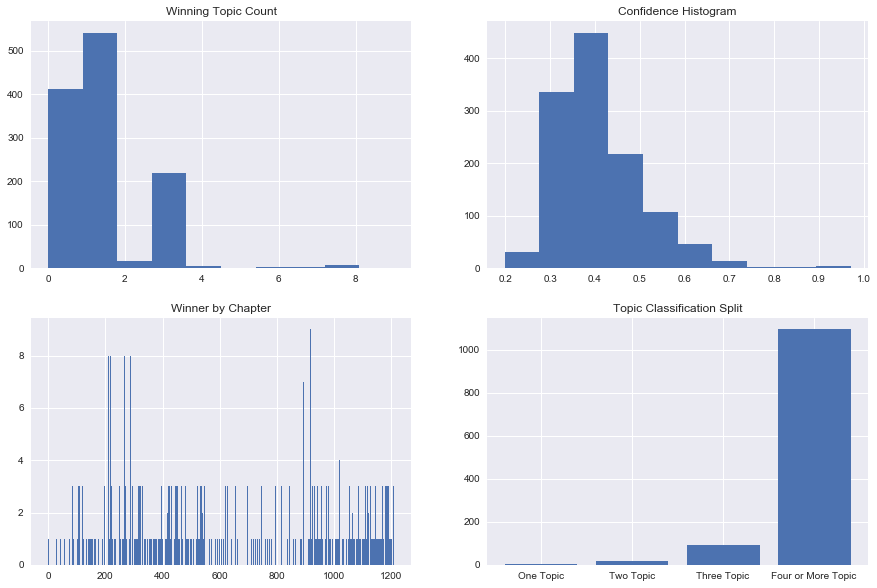

In [1653]:
# Transforming Primary doc's into correct vectorized matrix

sec_pri_countvec = vectorizer.transform(df_b_1865['chapter_lemma'])

pri_corpus_vect_gensim = gensim.matutils.Sparse2Corpus(sec_pri_countvec, documents_columns=False)

document_breakdown(pri_corpus_vect_gensim)

# 1865-1913

Bound of LDA model:  -1192317.7573064566
122


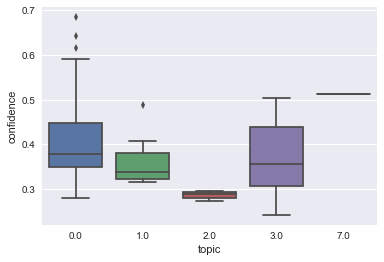

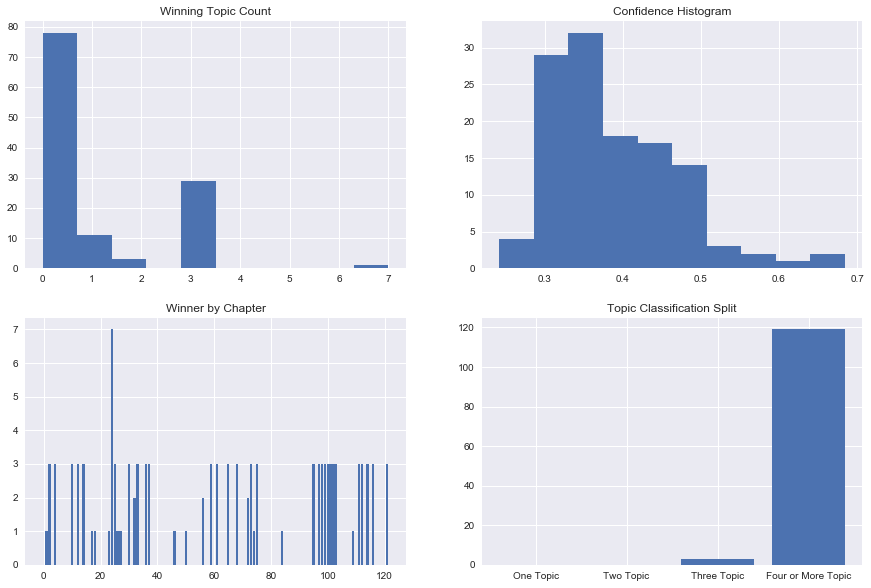

In [1654]:
# Transforming Primary doc's into correct vectorized matrix

sec_pri_countvec = vectorizer.transform(df_1865_1913['chapter_lemma'])

pri_corpus_vect_gensim = gensim.matutils.Sparse2Corpus(sec_pri_countvec, documents_columns=False)

document_breakdown(pri_corpus_vect_gensim)

# 1913 - 1945

Bound of LDA model:  -1192309.605424583
163


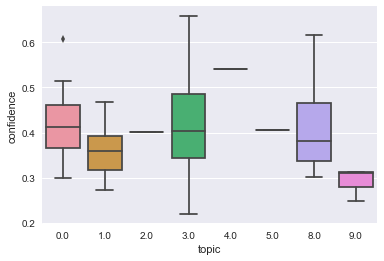

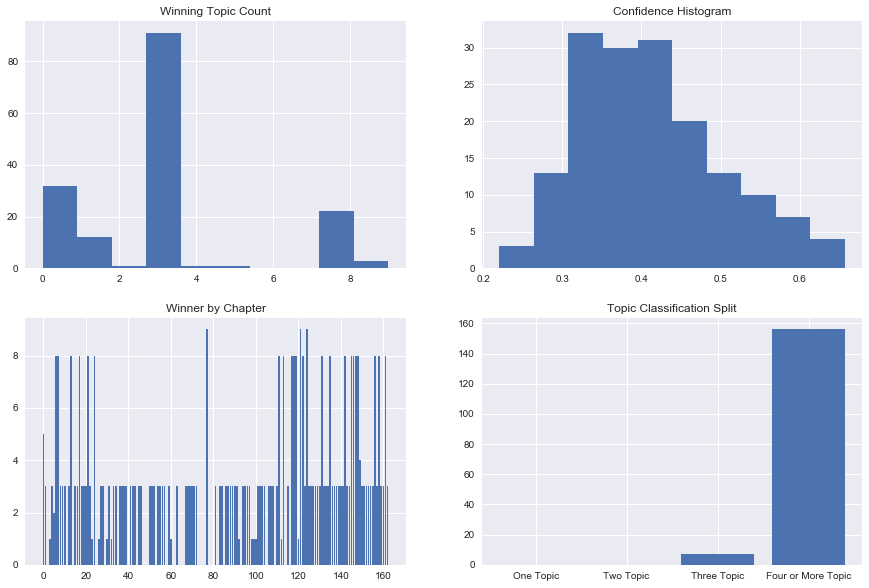

In [1655]:
# Transforming Primary doc's into correct vectorized matrix

sec_pri_countvec = vectorizer.transform(df_1913_1945['doc'])

pri_corpus_vect_gensim = gensim.matutils.Sparse2Corpus(sec_pri_countvec, documents_columns=False)

document_breakdown(pri_corpus_vect_gensim)

# After 1945



In [1638]:
sec_pri_countvec.shape

(163, 4793)

Bound of LDA model:  -933325.7623248696
166


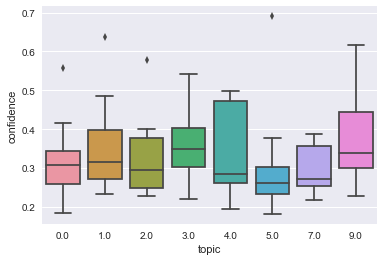

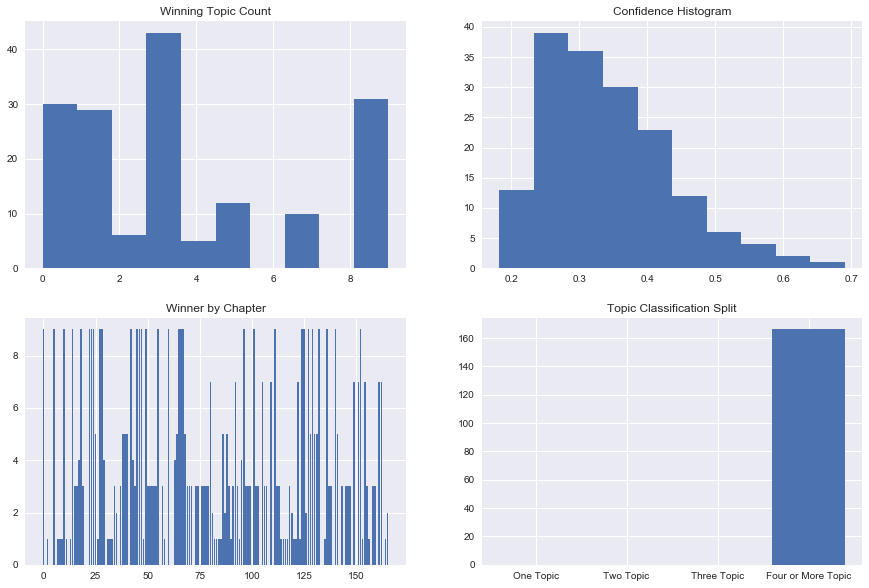

In [1640]:
# Transforming Primary doc's into correct vectorized matrix

sec_pri_countvec = vectorizer.transform(df_a_1945['chapter_lemma'])

pri_corpus_vect_gensim = gensim.matutils.Sparse2Corpus(sec_pri_countvec, documents_columns=False)

document_breakdown(pri_corpus_vect_gensim)

In [1706]:
# Estimate for the corpus
topic_count = []
confidence = []
both = []
one_topic = 0
two_topic = 0
three_topic = 0
four_more_topic = 0
for num, doc in enumerate(range(len(pri_corpus_vect_gensim))):
        item = lda_model.get_document_topics(pri_corpus_vect_gensim[num])
        if len(item) == 1:
            topic_count.append(item[0][0])
            confidence.append(item[0][1])
            one_topic += 1
        else:
            pickin_best = []
            for it in item:
                pickin_best.append(it[1])
            for it in item:
                for i in it:
                    topic_count.append(it[0])
                    confidence.append(it[1])
            if len(item) == 2:
                two_topic += 1
            if len(item) == 3:
                three_topic += 1
            if len(item) >= 4:
                four_more_topic += 1
    # Topic winners over time
enumed = list(range(len(topic_count)))
topic_winners_time = pd.DataFrame(data = [enumed, topic_count]).T
topic_winners_time.columns = ['chap_num', 'topic_winner']

IndexError: index 2106 is out of bounds for axis 1 with size 1498

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

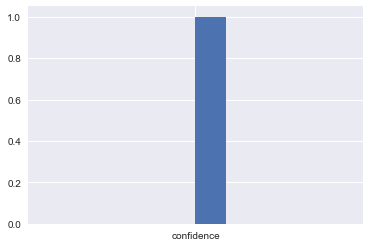

In [1594]:
plt.hist('confidence')

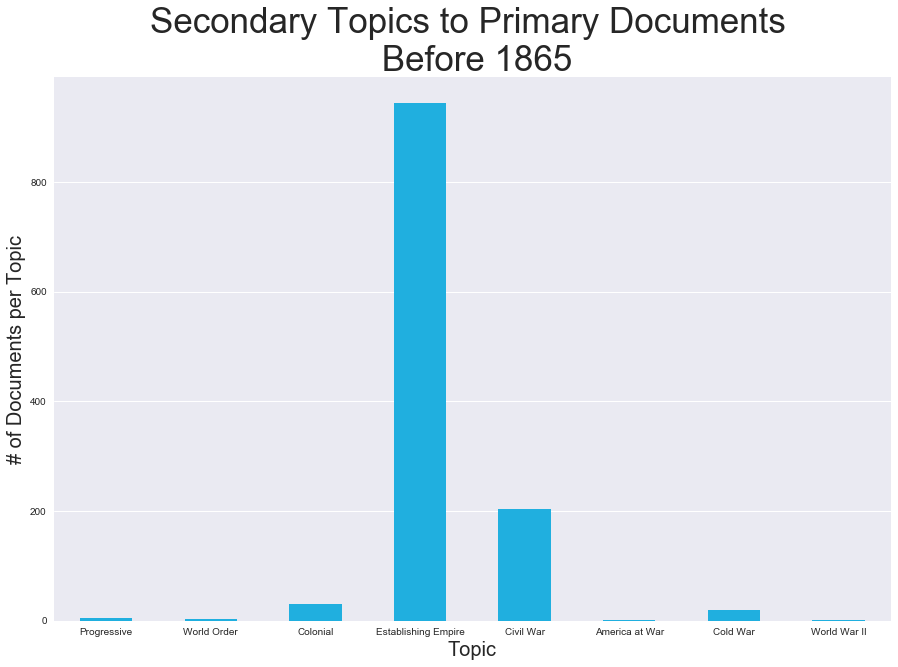

In [1561]:
topic_agg = topic_winners_time.groupby(by = 'topic_winner').count()

topic_agg.reset_index(inplace = True)

topic_map_names = {0 : 'Progressive', 1 : 'World Order', 2 : 'Colonial', 3 : 'Establishing Empire', 5 : '1930s',
                   6 : 'Civil War', 7 : 'America at War', 8 : 'Cold War', 9 : 'World War II' }

# replacement = 

topic_agg['topic_winner_names'] = topic_agg['topic_winner'].map(topic_map_names)




    
fig, ax = plt.subplots(figsize=(15,10))

sns.barplot(x = 'topic_winner_names', y = 'chap_num', data = topic_agg, color ="deepskyblue")

def change_width(ax, new_value) :
        for patch in ax.patches :
            current_width = patch.get_width()
            diff = current_width - new_value

            # we change the bar width
            patch.set_width(new_value)

            # we recenter the bar
            patch.set_x(patch.get_x() + diff * .5)
sns.set(font_scale=1)
plt.title('Secondary Topics to Primary Documents \n Before 1865', fontsize = 35)
plt.xlabel('Topic', fontsize = 20)
plt.ylabel('# of Documents per Topic', fontsize = 20)
#plt.legend(loc = 'upper left')
change_width(ax, .5)

plt.show()

### Presidential Primary Sources

In [ ]:
# Transforming Primary doc's into correct vectorized matrix

sec_pres_countvec = vectorizer.transform(df_pres['doc'])

pres_corpus_vect_gensim = gensim.matutils.Sparse2Corpus(sec_pres_countvec, documents_columns=False)


In [ ]:
document_breakdown(pres_corpus_vect_gensim)

### Progressive Era - title from document

In [ ]:
# Transforming Primary doc's into correct vectorized matrix

sec_pri_countvec = vectorizer.transform(df_prog['doc'])

pri_corpus_vect_gensim = gensim.matutils.Sparse2Corpus(sec_pri_countvec, documents_columns=False)

document_breakdown(pri_corpus_vect_gensim)

### DTM Modeling

In [1681]:
# Setting up the DTM corpus and for the pyLDA viz

id2word = corpora.Dictionary(corpus_all_list)

class DTMcorpus(corpora.textcorpus.TextCorpus):

    def get_texts(self):
        return self.input

    def __len__(self):
        return len(self.input)

corpus = DTMcorpus(corpus_all_list)

In [1665]:
year_all.head()

,Unnamed: 0,para,dates,para_lemma,len,year,avg_year,num_years,year_25group,year_50group
0,0,Bearing witness to this shocking act of brutal...,"['twenty-two-year-old', 'early May 1754', 'the...",bear witness shocking act brutality year old c...,118,[1754],1754,1,1775,1800
1,1,Washington had a personal as well as patriotic...,"['1752', 'age sixteen']",washington personal patriotic interest wrest o...,117,[1752],1752,1,1775,1800
2,2,Although Washington eagerly sought new wealth ...,"['1743', 'a century']",washington eagerly seek new wealth western lan...,70,[1743],1743,1,1750,1750
3,3,Knowing that the attack on Lieutenant Jumonvil...,"['July 3', 'torrential summer', 'July 3, 1754']",know attack lieutenant jumonville ’s force gen...,124,[1754],1754,1,1775,1800
4,4,George Washington’s botched mission to wester...,"['1756', 'June 1754', 'the previous winter']",george washington ’s botched mission western p...,95,"[1756, 1754]",1755,2,1775,1800


In [1670]:
year_all.groupby(by = 'year_25group').count()

,Unnamed: 0,para,dates,para_lemma,len,year,avg_year,num_years,year_50group
year_25group,,,,,,,,,
1750,6,6,6,6,6,6,6,6,6
1775,29,29,29,29,29,29,29,29,29
1800,56,56,56,56,56,56,56,56,56
1825,93,93,93,93,93,93,93,93,93
1850,102,102,102,102,102,102,102,102,102
1875,126,126,126,126,126,126,126,126,126
1900,230,230,230,230,230,230,230,230,230
1925,194,194,194,194,194,194,194,194,194
1950,233,233,233,233,233,233,233,233,233


In [1675]:
sum([6, 29, 56, 93, 102, 126, 230, 194, 233, 193, 132, 71])

1465

In [1702]:
# Save model to disk.
temp_file = datapath("mode")
lda_model.save(temp_file)

# loading it for good measure but the LDA model just needs to be saved in the same area to be initialized by dtm model
lda = LdaModel.load(temp_file)

# Setting up the other parameters to go in
dtm_path = '/Users/bengreer/Documents/github/DSI-US-5/Capstone/dtm/bin/dtm-darwin64'
time_seq = [6, 29, 56, 93, 102, 126, 230, 194, 233, 193, 132, 71] # the # of chapters which are included in each book, the largest timeframe I can have

model = DtmModel(dtm_path, corpus, time_seq, num_topics=10,
                 id2word=id2word, initialize_lda= True)

In [1696]:
# exploring the outcome of the DTM model
topics = model.show_topics(num_topics=1, formatted = False)
fig_size = (10,10)
word_impact = []
hist_word_double = []
for item in topics:
    word_impact = []
    hist_word = []
    for it in item:
        number, topic_word = it
        word_impact.append(number)
        hist_word.append(topic_word)
    hist_word_double.append(hist_word)
    hist_word_double.append(word_impact)
historical_dtm = pd.DataFrame(hist_word_double[:2]).T
historical_dtm_draft = pd.DataFrame(hist_word_double[2:4]).T
historical_dtm_draft2 = pd.DataFrame(hist_word_double[4:6]).T
historical_dtm_draft3 = pd.DataFrame(hist_word_double[6:8]).T
historical_dtm_draft4 = pd.DataFrame(hist_word_double[8:10]).T
historical_dtm = historical_dtm.merge(historical_dtm_draft, on = 0, how = 'outer')
historical_dtm = historical_dtm.merge(historical_dtm_draft2, on = 0, how = 'outer')
historical_dtm = historical_dtm.merge(historical_dtm_draft3, on = 0, how = 'outer')
historical_dtm = historical_dtm.merge(historical_dtm_draft4, on = 0, how = 'outer')
historical_dtm = historical_dtm.fillna(0)
historical_dtm.columns = ['word', 'Vanilla', 'South', 'Non Russia Communist', 'League of Nations', 'Communist','Progressive Era', 'World Order', 'Rober Baron', 'World War II', 'Asian Foreign Policy']
historical_dtm.set_index('word', inplace = True)
historical_dtm = historical_dtm.T
plt.plot(historical_dtm);


/Users/bengreer/anaconda3/lib/python3.6/site-packages/gensim/models/wrappers/dtmmodel.py:494: UserWarning: The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.
  warnings.warn("The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.")
/Users/bengreer/anaconda3/lib/python3.6/site-packages/gensim/models/wrappers/dtmmodel.py:494: UserWarning: The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.
  warnings.warn("The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.")
/Users/bengreer/anaconda3/lib/python3.6/site-packages/gensim/models/wrappers/dtmmodel.py:494: UserWarning: The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.
  warnings.warn("The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.")
/Users/bengreer/anaconda3/lib/python3.6/site-packages/gensim/models/wrappers/dtmmodel.py:494: UserWa

ValueError: Length mismatch: Expected axis has 6 elements, new values have 11 elements

In [ ]:
# exploring the outcome of the DTM model
topics = model.show_topics(num_topics=1, times=4, formatted = False, num_words = 10)
word_impact = []
hist_word_double = []
for item in topics:
    word_impact = []
    hist_word = []
    for it in item:
        number, topic_word = it
        word_impact.append(number)
        hist_word.append(topic_word)
    hist_word_double.append(hist_word)
    hist_word_double.append(word_impact)
historical_dtm = pd.DataFrame(hist_word_double[:2]).T
historical_dtm_draft = pd.DataFrame(hist_word_double[2:4]).T
historical_dtm_draft2 = pd.DataFrame(hist_word_double[4:6]).T
historical_dtm_draft3 = pd.DataFrame(hist_word_double[6:8]).T
historical_dtm = historical_dtm.merge(historical_dtm_draft, on = 0, how = 'outer')
historical_dtm = historical_dtm.merge(historical_dtm_draft2, on = 0, how = 'outer')
historical_dtm = historical_dtm.merge(historical_dtm_draft3, on = 0, how = 'outer')
historical_dtm = historical_dtm.fillna(0)
#historical_dtm.columns = ['word', 'Before_1865', '1865-1913', '1913-1945', '1945-Present']
historical_dtm.set_index('word', inplace = True)
historical_dtm = historical_dtm.T
plt.plot(historical_dtm);

In [143]:
def logdot(a, b):
    max_a, max_b = np.max(a), np.max(b)
    exp_a, exp_b = a - max_a, b - max_b
    np.exp(exp_a, out=exp_a)
    np.exp(exp_b, out=exp_b)
    c = np.dot(exp_a, exp_b)
    np.log(c, out=c)
    c += max_a + max_b
    return c

In [146]:
historical_dtm = historical_dtm.T

In [148]:
historical_dtm['1865-1913'][1]

0.0015824243803986419

In [152]:
a = scan("topic-002-var-e-log-prob.dat")

NameError: name 'scan' is not defined

In [151]:
for x in range(len(historical_dtm['1865-1913'])):
    print(logdot(historical_dtm['Before_1865'], historical_dtm['1865-1913'][x]))

TypeError: return arrays must be of ArrayType

In [133]:
historical_dtm = historical_dtm.T
for row in historical_dtm
historical_dtm['log_prob_1'] = np.log(historical_dtm['Before_1865'] + historical_dtm['1865-1913'])

KeyError: 'Before_1865'

In [ ]:
def read_topic_word_dist(topic, journal_df, output_prefix):
    word_dist_file = output_prefix + str(topic) + '-var-e-log-prob.dat'
    word_dist = np.fromfile(word_dist_file, sep='\n')
    
    # reshape the numpy array
    ncols = journal_df.pub_year.nunique()
    nrows = len(vocab)
    word_dist = np.reshape(word_dist, (nrows, ncols))
    
    # convert the numpy ndarray to pandas dataframe
    return pd.DataFrame(word_dist, 
                        columns=np.sort(journal_df.pub_year.unique()).tolist())

def top_words(topic_word_dist, vocab, year, num_words=10):
    indices = topic_word_dist.loc[:,year].sort_values(ascending=False).head(num_words).index
    return vocab.loc[indices, :]

def all_top_words(topics, journal_df, vocab, ouput_prefix):
    for topic in topics:
        word_dist = read_topic_word_dist(topic, journal_df, output_prefix)
        print('Topic {}'.format(topic))
        for year in np.sort(journal_df.pub_year.unique()):
            print("{}:\n{}\n".format(year, top_words(word_dist, vocab, year, 20).word.tolist()))
        print('-'*25)

output_prefix = '/media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run/lda-seq/topic-0'
n_topics = 10
topics = [str(i) if i > 9 else '0' + str(i) for i in range(n_topics)]

all_top_words(topics, , vocab, output_prefix)